In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, pearsonr
import statsmodels.api as sm

In [3]:
#Reimport clean data with correct category types
cat_dict = {'Distribution_channel': 'category', 'Payment': 'category', 'Type_risk': 'category', 'Area': 'category', 'Second_driver': 'category', 'Type_fuel': 'category'}

'../exports/clean_auto_data.csv', parse_dates=['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence', 'Date_lapse']

In [4]:
auto_df = pd.read_csv('../exports/clean_auto_data.csv', parse_dates=['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence', 'Date_lapse'])

/var/folders/k7/_jdxw9bx3_7cybsnkxz0pr200000gn/T/ipykernel_27187/4278244590.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  auto_df = pd.read_csv('../exports/clean_auto_data.csv', parse_dates=['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence', 'Date_lapse'])


In [5]:
auto_df.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,0,4,1,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,0,4,1,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,0,4,2,2,...,0,0,2004,80,599,7068.0,0,P,NaN,190


In [6]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103791 entries, 0 to 103790
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    103791 non-null  int64         
 1   Date_start_contract   103791 non-null  datetime64[ns]
 2   Date_last_renewal     103791 non-null  datetime64[ns]
 3   Date_next_renewal     103791 non-null  datetime64[ns]
 4   Date_birth            103791 non-null  datetime64[ns]
 5   Date_driving_licence  103791 non-null  datetime64[ns]
 6   Distribution_channel  103791 non-null  object        
 7   Seniority             103791 non-null  int64         
 8   Policies_in_force     103791 non-null  int64         
 9   Max_policies          103791 non-null  int64         
 10  Max_products          103791 non-null  int64         
 11  Lapse                 103791 non-null  int64         
 12  Date_lapse            34707 non-null   datetime64[ns]
 13 

In [7]:
# Adding a column for age of policy holder as that could be a factor in cost of Premium
auto_df['Age'] = (auto_df['Date_last_renewal'] - auto_df['Date_birth']) / pd.Timedelta(days=365.25)

In [8]:
auto_df['Distribution_channel'].value_counts()

Distribution_channel
0             31774
1             30433
0             21476
1             16779
00/01/1900     3329
Name: count, dtype: int64

In [9]:
mapping = {'0' : 0, '1': 1, 0: 0, 1: 1, '00/01/1900': 3}
s = auto_df['Distribution_channel']
s_encoded = s.map(mapping)
s_encoded.value_counts()
auto_df['Distribution_channel'] = s_encoded
# auto_df.info()
auto_df['Distribution_channel'].value_counts()
auto_df.dropna(subset=['Distribution_channel'], inplace=True)
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103791 entries, 0 to 103790
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    103791 non-null  int64         
 1   Date_start_contract   103791 non-null  datetime64[ns]
 2   Date_last_renewal     103791 non-null  datetime64[ns]
 3   Date_next_renewal     103791 non-null  datetime64[ns]
 4   Date_birth            103791 non-null  datetime64[ns]
 5   Date_driving_licence  103791 non-null  datetime64[ns]
 6   Distribution_channel  103791 non-null  int64         
 7   Seniority             103791 non-null  int64         
 8   Policies_in_force     103791 non-null  int64         
 9   Max_policies          103791 non-null  int64         
 10  Max_products          103791 non-null  int64         
 11  Lapse                 103791 non-null  int64         
 12  Date_lapse            34707 non-null   datetime64[ns]
 13 

Text(0, 0.5, 'Count')

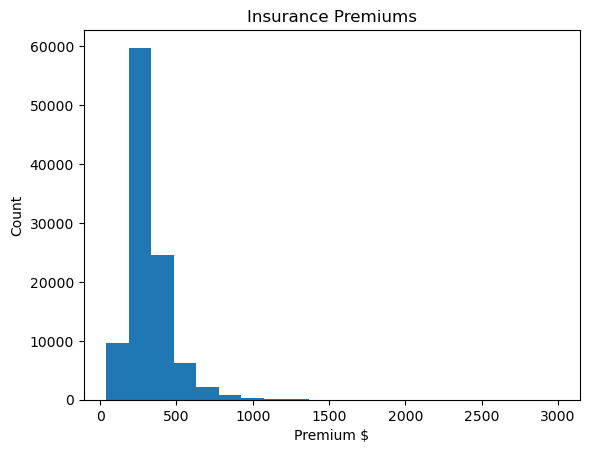

In [10]:
#Create a histogram of the variable we are trying to predict to get a good understanding of what the distribution is like

plt.hist(auto_df['Premium'], bins=20)
plt.title('Insurance Premiums')
plt.xlabel('Premium $')
plt.ylabel('Count')

In [11]:
premium_logged = np.log(auto_df['Premium'])

(array([9.0600e+02, 1.2630e+03, 4.2480e+03, 1.1544e+04, 5.5133e+04,
        2.3894e+04, 5.7490e+03, 9.4000e+02, 1.0300e+02, 1.1000e+01]),
 array([3.69237334, 4.12355052, 4.55472769, 4.98590487, 5.41708205,
        5.84825922, 6.2794364 , 6.71061357, 7.14179075, 7.57296792,
        8.0041451 ]),
 <BarContainer object of 10 artists>)

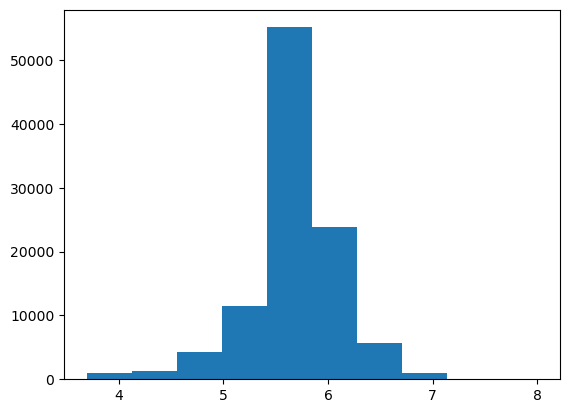

In [12]:
plt.hist(premium_logged)

In [13]:
np.set_printoptions(precision=10)
stat, pvalue = kstest(premium_logged, 'norm')
print(pvalue)

0.0


In [14]:
#check the summary statistics
auto_df['Premium'].describe()

count    103791.000000
mean        318.829519
std         140.042785
min          40.140000
25%         244.050000
50%         293.950000
75%         363.260000
max        2993.340000
Name: Premium, dtype: float64

In [15]:
#create a new df that contains only the numeric datatypes to begin checking correlation
numeric_cols = auto_df.select_dtypes(include=[np.number])

In [16]:
numeric_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103791 entries, 0 to 103790
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    103791 non-null  int64  
 1   Distribution_channel  103791 non-null  int64  
 2   Seniority             103791 non-null  int64  
 3   Policies_in_force     103791 non-null  int64  
 4   Max_policies          103791 non-null  int64  
 5   Max_products          103791 non-null  int64  
 6   Lapse                 103791 non-null  int64  
 7   Payment               103791 non-null  int64  
 8   Premium               103791 non-null  float64
 9   Cost_claims_year      103791 non-null  float64
 10  N_claims_year         103791 non-null  int64  
 11  N_claims_history      103791 non-null  int64  
 12  R_Claims_history      103791 non-null  float64
 13  Type_risk             103791 non-null  int64  
 14  Area                  103791 non-null  int64  
 15  

In [17]:
numeric_cols1 = numeric_cols.dropna()
numeric_cols1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95226 entries, 6 to 103790
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    95226 non-null  int64  
 1   Distribution_channel  95226 non-null  int64  
 2   Seniority             95226 non-null  int64  
 3   Policies_in_force     95226 non-null  int64  
 4   Max_policies          95226 non-null  int64  
 5   Max_products          95226 non-null  int64  
 6   Lapse                 95226 non-null  int64  
 7   Payment               95226 non-null  int64  
 8   Premium               95226 non-null  float64
 9   Cost_claims_year      95226 non-null  float64
 10  N_claims_year         95226 non-null  int64  
 11  N_claims_history      95226 non-null  int64  
 12  R_Claims_history      95226 non-null  float64
 13  Type_risk             95226 non-null  int64  
 14  Area                  95226 non-null  int64  
 15  Second_driver         9

In [18]:
numeric_cols1.corr()

,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Age
ID,1.000000,-0.141352,-0.131236,-0.041383,-0.072223,-0.062136,0.026554,0.036552,0.018593,0.010053,...,-0.072440,-0.050622,-0.002373,0.032966,0.039695,0.027341,0.004226,0.041228,0.034695,-0.211144
Distribution_channel,-0.141352,1.000000,-0.154123,-0.034913,-0.066688,-0.035902,0.033192,0.044633,0.050479,0.005359,...,0.095519,0.039099,0.021067,0.005357,0.017564,0.005371,0.009170,0.025189,0.018951,0.014236
Seniority,-0.131236,-0.154123,1.000000,0.025876,0.241914,0.221048,-0.064314,-0.171295,-0.070993,-0.022670,...,0.001672,-0.078553,-0.103561,-0.061969,-0.025191,-0.058219,-0.043236,-0.048144,-0.044039,0.189730
Policies_in_force,-0.041383,-0.034913,0.025876,1.000000,0.775061,0.057890,0.197834,0.050518,-0.050662,0.018259,...,-0.045361,0.070416,-0.057969,0.036666,0.075918,0.082588,-0.022386,0.079602,0.084252,0.028558
Max_policies,-0.072223,-0.066688,0.241914,0.775061,1.000000,0.262791,0.176415,0.024031,-0.037896,0.011065,...,-0.032869,0.039764,-0.058188,0.047970,0.087367,0.087161,-0.026240,0.092189,0.095449,0.077750
Max_products,-0.062136,-0.035902,0.221048,0.057890,0.262791,1.000000,0.015709,-0.017660,-0.012741,0.000065,...,0.024453,-0.003113,-0.017774,0.015312,0.019306,0.017073,0.000332,0.015271,0.014075,0.082830
Lapse,0.026554,0.033192,-0.064314,0.197834,0.176415,0.015709,1.000000,0.073990,0.065049,-0.010191,...,0.034577,-0.015062,-0.114471,-0.003849,0.051477,-0.003142,-0.046332,0.016269,0.010764,-0.024334
Payment,0.036552,0.044633,-0.171295,0.050518,0.024031,-0.017660,0.073990,1.000000,0.187958,0.028597,...,0.042264,0.029530,0.002497,0.036117,0.027865,0.021526,-0.002354,0.037889,0.030398,-0.129698
Premium,0.018593,0.050479,-0.070993,-0.050662,-0.037896,-0.012741,0.065049,0.187958,1.000000,0.047511,...,0.083524,0.107512,0.287014,0.282626,0.123152,0.340708,0.030763,0.195998,0.216801,-0.101747
Cost_claims_year,0.010053,0.005359,-0.022670,0.018259,0.011065,0.000065,-0.010191,0.028597,0.047511,1.000000,...,0.009096,0.010297,0.012815,0.019439,0.013736,0.022459,-0.006611,0.018452,0.018193,-0.021823


In [19]:
#run .corr() method to check the pearson coefficient for each feature.
# since we are interested in predicting the Premium, we will check to see what features may correlate with it
numeric_cols.corr()

,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Age
ID,1.000000,-0.142129,-0.127921,-0.046406,-0.074208,-0.059788,0.025877,0.043988,0.038909,0.011430,...,-0.078707,-0.042830,0.024780,0.047308,0.036404,0.032196,0.037848,0.041228,0.026696,-0.211443
Distribution_channel,-0.142129,1.000000,-0.147438,-0.034709,-0.064891,-0.033267,0.031241,0.043554,0.050705,0.005355,...,0.095733,0.038258,0.027839,0.013808,0.015408,0.008579,0.016023,0.025189,0.012386,0.011734
Seniority,-0.127921,-0.147438,1.000000,0.027500,0.238598,0.216541,-0.061591,-0.160146,-0.057175,-0.021821,...,-0.005522,-0.073206,-0.104394,-0.030920,0.039850,-0.017515,-0.002227,-0.048144,0.048699,0.192916
Policies_in_force,-0.046406,-0.034709,0.027500,1.000000,0.779066,0.053538,0.200335,0.041482,-0.058882,0.017453,...,-0.041943,0.063482,-0.077604,0.020654,0.047778,0.065557,-0.028258,0.079602,0.047169,0.031579
Max_policies,-0.074208,-0.064891,0.238598,0.779066,1.000000,0.257078,0.178804,0.016366,-0.046736,0.010484,...,-0.031718,0.034254,-0.076889,0.028550,0.056117,0.069704,-0.031771,0.092189,0.054806,0.077641
Max_products,-0.059788,-0.033267,0.216541,0.053538,0.257078,1.000000,0.016272,-0.019137,-0.015345,-0.000330,...,0.024930,-0.004722,-0.019862,0.008289,0.010619,0.012684,-0.008901,0.015271,0.005484,0.079045
Lapse,0.025877,0.031241,-0.061591,0.200335,0.178804,0.016272,1.000000,0.071704,0.059834,-0.010046,...,0.033050,-0.014232,-0.099432,-0.001644,0.033472,-0.003081,-0.025476,0.016269,0.005958,-0.026988
Payment,0.043988,0.043554,-0.160146,0.041482,0.016366,-0.019137,0.071704,1.000000,0.239653,0.032203,...,0.034801,0.048562,0.021288,0.123087,0.109423,0.082605,0.139963,0.037889,0.104243,-0.129349
Premium,0.038909,0.050705,-0.057175,-0.058882,-0.046736,-0.015345,0.059834,0.239653,1.000000,0.052589,...,0.065107,0.137869,0.287715,0.407512,0.256568,0.403965,0.309248,0.195998,0.285017,-0.110725
Cost_claims_year,0.011430,0.005355,-0.021821,0.017453,0.010484,-0.000330,-0.010046,0.032203,0.052589,1.000000,...,0.008217,0.012604,0.014307,0.027653,0.020489,0.027692,0.014673,0.018452,0.021402,-0.021942


In [20]:
numeric_cols1.corr() - numeric_cols.corr()

,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Age
ID,0.000000,0.000777,-0.003315,0.005024,0.001985,-0.002348,0.000677,-0.007436,-0.020316,-0.001377,...,0.006267,-0.007792,-0.027153,-0.014341,0.003292,-0.004855,-0.033622,0.0,0.007999,0.000299
Distribution_channel,0.000777,0.000000,-0.006685,-0.000204,-0.001797,-0.002635,0.001951,0.001079,-0.000226,0.000004,...,-0.000214,0.000841,-0.006771,-0.008452,0.002156,-0.003208,-0.006853,0.0,0.006566,0.002503
Seniority,-0.003315,-0.006685,0.000000,-0.001625,0.003316,0.004508,-0.002723,-0.011150,-0.013817,-0.000849,...,0.007194,-0.005347,0.000833,-0.031049,-0.065041,-0.040705,-0.041008,0.0,-0.092738,-0.003187
Policies_in_force,0.005024,-0.000204,-0.001625,0.000000,-0.004005,0.004352,-0.002501,0.009035,0.008220,0.000806,...,-0.003418,0.006934,0.019634,0.016012,0.028140,0.017031,0.005873,0.0,0.037083,-0.003021
Max_policies,0.001985,-0.001797,0.003316,-0.004005,0.000000,0.005713,-0.002388,0.007666,0.008841,0.000580,...,-0.001151,0.005510,0.018700,0.019420,0.031250,0.017457,0.005531,0.0,0.040643,0.000108
Max_products,-0.002348,-0.002635,0.004508,0.004352,0.005713,0.000000,-0.000563,0.001477,0.002604,0.000395,...,-0.000477,0.001609,0.002088,0.007023,0.008687,0.004389,0.009233,0.0,0.008591,0.003785
Lapse,0.000677,0.001951,-0.002723,-0.002501,-0.002388,-0.000563,0.000000,0.002287,0.005215,-0.000145,...,0.001527,-0.000830,-0.015039,-0.002205,0.018005,-0.000061,-0.020856,0.0,0.004806,0.002653
Payment,-0.007436,0.001079,-0.011150,0.009035,0.007666,0.001477,0.002287,0.000000,-0.051695,-0.003606,...,0.007463,-0.019032,-0.018791,-0.086970,-0.081558,-0.061079,-0.142317,0.0,-0.073845,-0.000348
Premium,-0.020316,-0.000226,-0.013817,0.008220,0.008841,0.002604,0.005215,-0.051695,0.000000,-0.005079,...,0.018417,-0.030357,-0.000700,-0.124886,-0.133416,-0.063257,-0.278485,0.0,-0.068216,0.008978
Cost_claims_year,-0.001377,0.000004,-0.000849,0.000806,0.000580,0.000395,-0.000145,-0.003606,-0.005079,0.000000,...,0.000879,-0.002307,-0.001492,-0.008214,-0.006753,-0.005233,-0.021284,0.0,-0.003209,0.000119


Text(0, 0.5, 'Premium $')

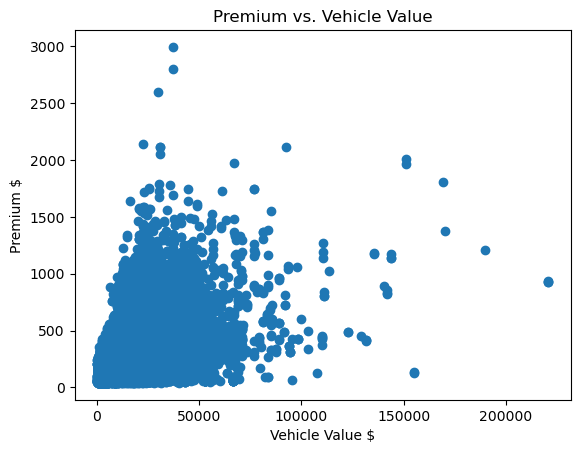

In [21]:
# It appears that only a few features are moderately correlated with none showing strong correlations.
# Create a scatterplot for each of the moderately correlated features (Vehicle Value, Power)

plt.scatter(auto_df['Value_vehicle'], auto_df['Premium'])
plt.title('Premium vs. Vehicle Value')
plt.xlabel('Vehicle Value $')
plt.ylabel('Premium $')

In [22]:
vv_corr, vv_pval = pearsonr(auto_df['Value_vehicle'], auto_df['Premium'])
print(vv_corr, vv_pval)

0.40396479393052886 0.0


In [23]:
x_const = sm.add_constant(auto_df['Value_vehicle'])
y_t = auto_df['Premium']
samp_model = sm.OLS(y_t, x_const).fit()

In [24]:
samp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                 2.024e+04
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:13:46   Log-Likelihood:            -6.5096e+05
No. Observations:              103791   AIC:                         1.302e+06
Df Residuals:                  103789   BIC:                         1.302e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           201.6222      0.915    220.401      0.000     199.829     203.415
Value_vehicle     0.0063   4.42e-05    142.267      0.000       0.006       0.006
==============================================================================
Omnibus:                    52916.481   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           894589.360
Skew:                           2.059   Prob(JB):                         0.00
Kurtosis:                      16.781   Cond. No.                     4.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
x_const3 = sm.add_constant(auto_df['Power'])
y_t3 = auto_df['Premium']
samp4_model = sm.OLS(y_t3, x_const3).fit()

In [46]:
samp4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                 2.067e+04
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:46:19   Log-Likelihood:            -6.5078e+05
No. Observations:              103791   AIC:                         1.302e+06
Df Residuals:                  103789   BIC:                         1.302e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        166.3615      1.132    146.910      0.000     164.142     168.581
Power          1.6176      0.011    143.764      0.000       1.596       1.640
==============================================================================
Omnibus:                    57763.234   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           986967.531
Skew:                           2.319   Prob(JB):                         0.00
Kurtosis:                      17.377   Cond. No.                         287.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Premium $')

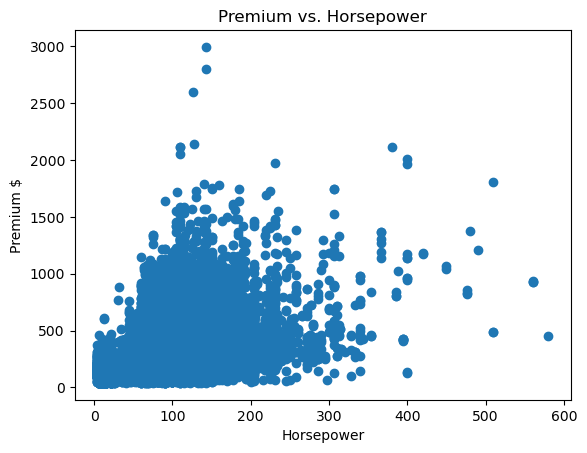

In [25]:
plt.scatter(auto_df['Power'], auto_df['Premium'])
plt.title('Premium vs. Horsepower')
plt.xlabel('Horsepower')
plt.ylabel('Premium $')

Text(0, 0.5, 'Premium')

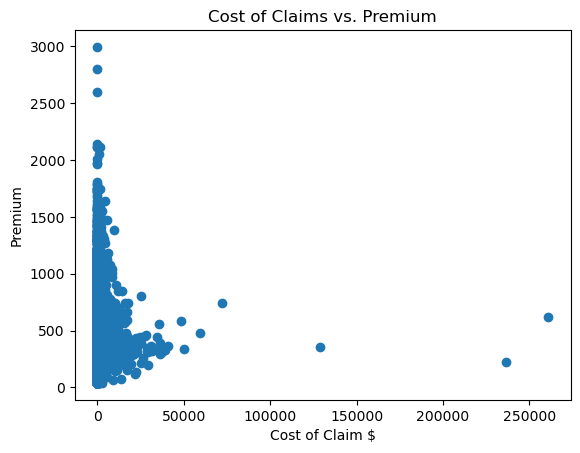

In [26]:
plt.scatter(auto_df['Cost_claims_year'], auto_df['Premium'])
plt.title('Cost of Claims vs. Premium')
plt.xlabel('Cost of Claim $')
plt.ylabel('Premium')

Text(0, 0.5, 'Premium')

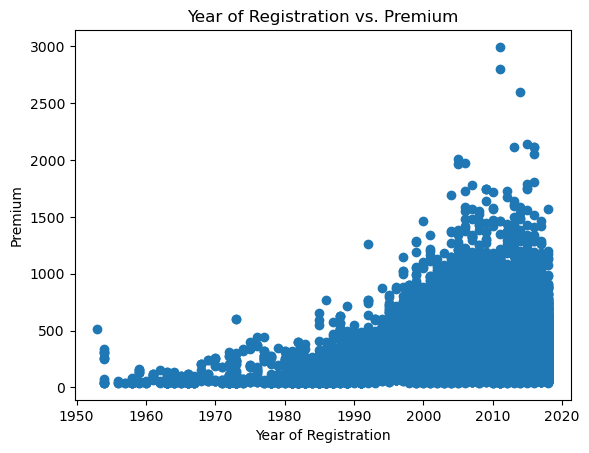

In [27]:
#Although the Year the car was registered is not linearly correlated with premium, it does appear to have some exponential correlation
plt.scatter(auto_df['Year_matriculation'], auto_df['Premium'])
plt.title('Year of Registration vs. Premium')
plt.xlabel('Year of Registration')
plt.ylabel('Premium')

Text(0, 0.5, 'Log Premium')

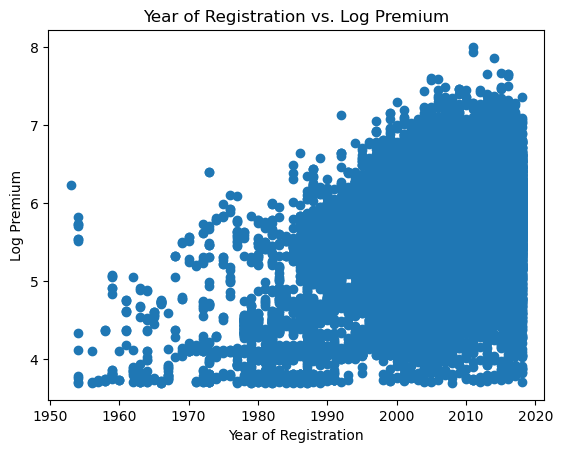

In [28]:
auto_df['log_prem'] = np.log(auto_df['Premium'])
# auto_df[['Year_matriculation', 'sqrt_year']]
plt.scatter(auto_df['Year_matriculation'], auto_df['log_prem'])
plt.title('Year of Registration vs. Log Premium')
plt.xlabel('Year of Registration')
plt.ylabel('Log Premium')

In [29]:
log_corr, log_pval = pearsonr(auto_df['Year_matriculation'], auto_df['log_prem'])
print(log_corr, log_pval)

0.3173032328612062 0.0


In [30]:
x_const1 = sm.add_constant(auto_df['Year_matriculation'])
y_t1 = auto_df['Premium']
samp_model2 = sm.OLS(y_t1, x_const1).fit()

In [31]:
print(samp_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                Premium   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9367.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:13:49   Log-Likelihood:            -6.5572e+05
No. Observations:              103791   AIC:                         1.311e+06
Df Residuals:                  103789   BIC:                         1.311e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.258e+04    133

Text(0, 0.5, 'Premium')

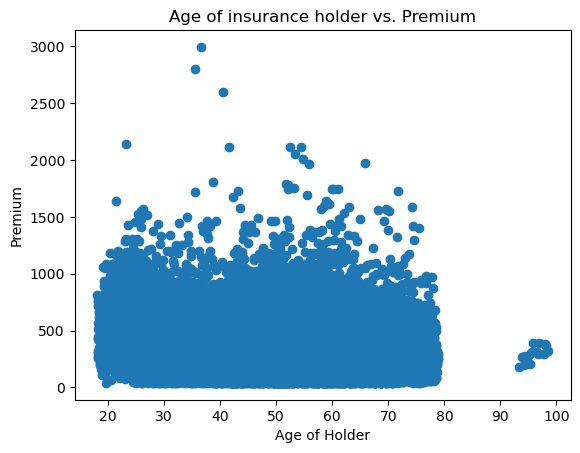

In [32]:
#Appears to be a slightly negative correlation between the two
plt.scatter(auto_df['Age'], auto_df['Premium'])
plt.title('Age of insurance holder vs. Premium')
plt.xlabel('Age of Holder')
plt.ylabel('Premium')

/Users/matthewelmajian/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Distribution by type of Risk')

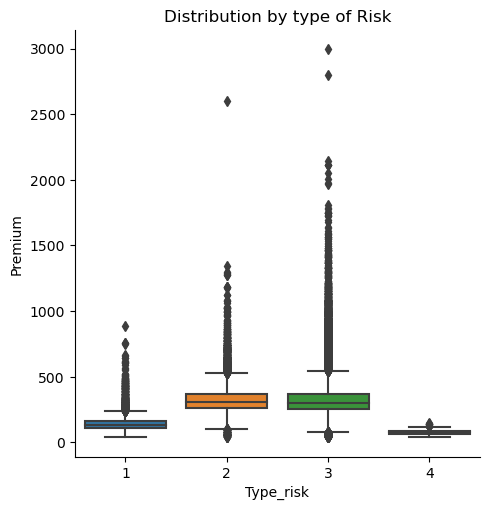

In [33]:
sns.catplot(x = 'Type_risk', y = 'Premium', data=auto_df, kind='box')
plt.title('Distribution by type of Risk')

In [34]:
df_2018 = auto_df[auto_df['Date_last_renewal'] > '2017-12-31']

In [35]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35142 entries, 3 to 103790
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    35142 non-null  int64         
 1   Date_start_contract   35142 non-null  datetime64[ns]
 2   Date_last_renewal     35142 non-null  datetime64[ns]
 3   Date_next_renewal     35142 non-null  datetime64[ns]
 4   Date_birth            35142 non-null  datetime64[ns]
 5   Date_driving_licence  35142 non-null  datetime64[ns]
 6   Distribution_channel  35142 non-null  int64         
 7   Seniority             35142 non-null  int64         
 8   Policies_in_force     35142 non-null  int64         
 9   Max_policies          35142 non-null  int64         
 10  Max_products          35142 non-null  int64         
 11  Lapse                 35142 non-null  int64         
 12  Date_lapse            4726 non-null   datetime64[ns]
 13  Payment             

In [36]:
df_2018['Distribution_channel'].value_counts()

Distribution_channel
0    18178
1    15846
3     1118
Name: count, dtype: int64

In [37]:
df_2018.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Age,log_prem
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,0,4,2,2,...,2004,80,599,7068.00,0,P,NaN,190,62.557153,5.379851
5,2,2017-09-26,2018-09-26,2019-09-26,1956-04-15,1976-03-20,0,4,2,2,...,2004,80,599,7068.00,0,P,NaN,190,62.447639,5.374491
9,3,2013-11-29,2018-11-29,2019-11-29,1975-03-18,1995-07-10,0,15,1,2,...,2013,85,1229,16030.00,5,P,3.999,1105,43.701574,5.980075
12,4,2016-10-21,2018-10-21,2019-10-21,1973-07-10,1993-07-05,0,3,2,2,...,1986,6,74,1261.82,0,P,NaN,87,45.281314,4.777189
14,5,2017-05-12,2018-05-12,2019-05-12,1973-07-10,1993-07-05,0,3,2,2,...,1986,6,244,3000.00,0,P,NaN,92,44.837782,4.395066


In [38]:
numeric_cols_2018 = df_2018.select_dtypes(include=[np.number])

In [39]:
numeric_cols_2018.corr()

,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,...,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Age,log_prem
ID,1.000000,-0.148548,-0.124021,-0.057439,-0.085672,-0.058257,0.016829,0.029092,0.044344,0.006306,...,-0.047622,0.026377,0.047420,0.041860,0.033556,0.038923,0.041206,0.032932,-0.199644,0.070335
Distribution_channel,-0.148548,1.000000,-0.138896,-0.038432,-0.061097,-0.029953,0.024622,0.034938,0.046043,0.006671,...,0.038043,0.029665,0.015310,0.016063,0.010648,0.015739,0.019007,0.011227,0.019245,0.048146
Seniority,-0.124021,-0.138896,1.000000,0.033739,0.234247,0.212435,-0.005648,-0.130786,-0.035307,-0.034822,...,-0.066870,-0.099019,-0.025080,0.035452,-0.015238,0.006510,-0.043097,0.045710,0.196739,-0.030326
Policies_in_force,-0.057439,-0.038432,0.033739,1.000000,0.840086,0.041991,0.152767,0.046431,-0.070277,0.036740,...,0.058771,-0.095824,0.025481,0.056436,0.066036,-0.018184,0.073763,0.052902,0.025872,-0.103702
Max_policies,-0.085672,-0.061097,0.234247,0.840086,1.000000,0.220556,0.154738,0.034012,-0.043777,0.031309,...,0.032369,-0.095216,0.032416,0.063079,0.072547,-0.017478,0.085430,0.062667,0.071344,-0.071696
Max_products,-0.058257,-0.029953,0.212435,0.041991,0.220556,1.000000,0.003701,-0.013157,-0.014113,0.002803,...,-0.002533,-0.020707,0.002690,0.004388,0.003814,-0.008863,0.007398,0.001878,0.076280,-0.015831
Lapse,0.016829,0.024622,-0.005648,0.152767,0.154738,0.003701,1.000000,0.020941,0.066858,-0.001025,...,-0.008120,-0.068766,-0.000431,0.025603,-0.000838,-0.023172,0.012201,0.003943,-0.019754,0.064925
Payment,0.029092,0.034938,-0.130786,0.046431,0.034012,-0.013157,0.020941,1.000000,0.241270,0.034435,...,0.051094,0.012888,0.117143,0.109317,0.078435,0.139709,0.026517,0.109035,-0.119858,0.275814
Premium,0.044344,0.046043,-0.035307,-0.070277,-0.043777,-0.014113,0.066858,0.241270,1.000000,0.059229,...,0.146600,0.265599,0.377976,0.249546,0.386377,0.317043,0.181454,0.300858,-0.114247,0.915371
Cost_claims_year,0.006306,0.006671,-0.034822,0.036740,0.031309,0.002803,-0.001025,0.034435,0.059229,1.000000,...,0.026958,0.010767,0.027714,0.023906,0.029442,0.016171,0.017658,0.024810,-0.022724,0.053306


In [40]:
auto_5_door = numeric_cols[numeric_cols['N_doors'] == 5]

In [41]:
auto_5_door.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63957 entries, 6 to 103790
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    63957 non-null  int64  
 1   Distribution_channel  63957 non-null  int64  
 2   Seniority             63957 non-null  int64  
 3   Policies_in_force     63957 non-null  int64  
 4   Max_policies          63957 non-null  int64  
 5   Max_products          63957 non-null  int64  
 6   Lapse                 63957 non-null  int64  
 7   Payment               63957 non-null  int64  
 8   Premium               63957 non-null  float64
 9   Cost_claims_year      63957 non-null  float64
 10  N_claims_year         63957 non-null  int64  
 11  N_claims_history      63957 non-null  int64  
 12  R_Claims_history      63957 non-null  float64
 13  Type_risk             63957 non-null  int64  
 14  Area                  63957 non-null  int64  
 15  Second_driver         6

In [42]:
auto_5_door.corr()

,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Age
ID,1.000000,-0.144052,-0.121096,-0.045502,-0.076194,-0.060129,0.025485,0.032568,0.012278,0.008806,...,-0.080814,-0.046240,-0.022035,0.028451,0.045006,0.021473,NaN,0.038484,0.032735,-0.206647
Distribution_channel,-0.144052,1.000000,-0.157861,-0.034548,-0.069516,-0.036608,0.035875,0.045099,0.049227,0.005886,...,0.097327,0.042201,0.008676,0.003770,0.019223,0.003701,NaN,0.018372,0.016302,0.018304
Seniority,-0.121096,-0.157861,1.000000,0.040069,0.268803,0.225465,-0.062837,-0.164562,-0.062262,-0.022960,...,-0.001051,-0.080231,-0.068261,-0.033417,-0.013264,-0.036244,NaN,-0.028419,-0.019866,0.179319
Policies_in_force,-0.045502,-0.034548,0.040069,1.000000,0.772157,0.057150,0.177710,0.038311,-0.060357,0.023299,...,-0.045245,0.070875,-0.046447,0.030052,0.079318,0.087976,NaN,0.076409,0.073868,0.037622
Max_policies,-0.076194,-0.069516,0.268803,0.772157,1.000000,0.266879,0.164203,0.010802,-0.044566,0.014260,...,-0.030101,0.038904,-0.041462,0.040360,0.085822,0.092215,NaN,0.090655,0.090095,0.085026
Max_products,-0.060129,-0.036608,0.225465,0.057150,0.266879,1.000000,0.011807,-0.007840,-0.008363,0.004922,...,0.033707,-0.002489,-0.015129,0.015907,0.020896,0.019879,NaN,0.017164,0.021505,0.078213
Lapse,0.025485,0.035875,-0.062837,0.177710,0.164203,0.011807,1.000000,0.070852,0.065319,-0.011387,...,0.034204,-0.014820,-0.116142,-0.009522,0.062530,-0.004929,NaN,0.019098,0.015927,-0.018999
Payment,0.032568,0.045099,-0.164562,0.038311,0.010802,-0.007840,0.070852,1.000000,0.183087,0.026359,...,0.041936,0.029593,-0.009971,0.017632,0.025120,0.007123,NaN,0.034660,0.023209,-0.118859
Premium,0.012278,0.049227,-0.062262,-0.060357,-0.044566,-0.008363,0.065319,0.183087,1.000000,0.047960,...,0.086884,0.109311,0.290946,0.261908,0.082866,0.321926,NaN,0.188796,0.199588,-0.101955
Cost_claims_year,0.008806,0.005886,-0.022960,0.023299,0.014260,0.004922,-0.011387,0.026359,0.047960,1.000000,...,0.010594,0.013886,0.012849,0.014613,0.009521,0.019727,NaN,0.016905,0.015918,-0.017604


Text(0, 0.5, 'Power')

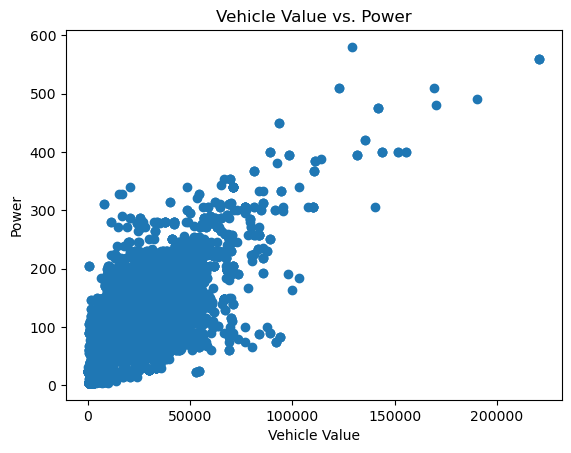

In [44]:
plt.scatter(auto_df['Value_vehicle'], auto_df['Power'])
plt.title('Vehicle Value vs. Power')
plt.xlabel('Vehicle Value')
plt.ylabel('Power')

Text(0, 0.5, 'Power')

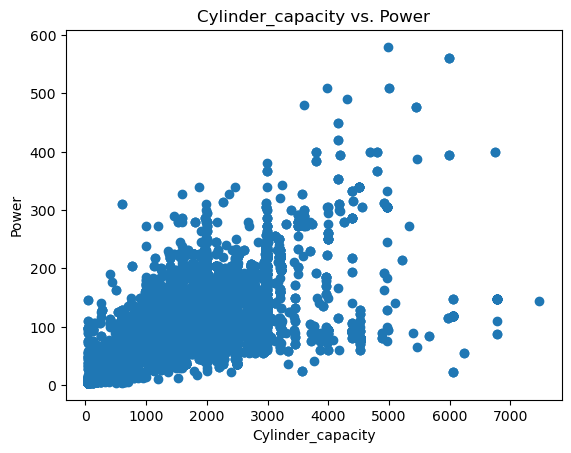

In [47]:
plt.scatter(auto_df['Cylinder_capacity'], auto_df['Power'])
plt.title('Cylinder_capacity vs. Power')
plt.xlabel('Cylinder_capacity')
plt.ylabel('Power')

In [26]:
(auto_df['ID'].value_counts()>1).count()

52645

In [49]:
auto_df['Type_risk'].value_counts()

Type_risk
3    82990
2    13212
1     6857
4      732
Name: count, dtype: int64

In [50]:
passenger_auto_df = auto_df[auto_df['Type_risk'] == 3]
passenger_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82990 entries, 6 to 103790
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    82990 non-null  int64         
 1   Date_start_contract   82990 non-null  datetime64[ns]
 2   Date_last_renewal     82990 non-null  datetime64[ns]
 3   Date_next_renewal     82990 non-null  datetime64[ns]
 4   Date_birth            82990 non-null  datetime64[ns]
 5   Date_driving_licence  82990 non-null  datetime64[ns]
 6   Distribution_channel  82990 non-null  object        
 7   Seniority             82990 non-null  int64         
 8   Policies_in_force     82990 non-null  int64         
 9   Max_policies          82990 non-null  int64         
 10  Max_products          82990 non-null  int64         
 11  Lapse                 82990 non-null  int64         
 12  Date_lapse            27919 non-null  datetime64[ns]
 13  Payment             

In [51]:
passenger_auto_df_numeric = passenger_auto_df.select_dtypes(include=[np.number])

In [52]:
numeric_risk_adj_df.corr()

NameError: name 'numeric_risk_adj_df' is not defined

In [64]:
passenger_auto_df['Age'] = round((passenger_auto_df['Date_last_renewal'] - passenger_auto_df['Date_birth']) / pd.Timedelta(days=365.25),1)

/var/folders/k7/_jdxw9bx3_7cybsnkxz0pr200000gn/T/ipykernel_33060/1435387893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_auto_df['Age'] = round((passenger_auto_df['Date_last_renewal'] - passenger_auto_df['Date_birth']) / pd.Timedelta(days=365.25),1)


In [65]:
passenger_auto_df.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Age
6,3,2013-11-29,2015-11-29,2016-11-29,1975-03-18,1995-07-10,0,15,1,2,...,0,2013,85,1229,16030.0,5,P,3.999,1105,40.7
7,3,2013-11-29,2016-11-29,2017-11-29,1975-03-18,1995-07-10,0,15,1,2,...,0,2013,85,1229,16030.0,5,P,3.999,1105,41.7
8,3,2013-11-29,2017-11-29,2018-11-29,1975-03-18,1995-07-10,0,15,1,2,...,0,2013,85,1229,16030.0,5,P,3.999,1105,42.7
9,3,2013-11-29,2018-11-29,2019-11-29,1975-03-18,1995-07-10,0,15,1,2,...,0,2013,85,1229,16030.0,5,P,3.999,1105,43.7
15,6,2006-05-29,2016-05-29,2017-05-29,1966-10-21,1990-09-10,0,13,1,2,...,0,2006,87,1598,9927.0,4,P,4.250,1055,49.6


In [62]:
passenger_auto_df_numeric = passenger_auto_df.select_dtypes(include=[np.number])

In [63]:
passenger_auto_df_numeric.corr()

,ID,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,N_claims_year,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Age
ID,1.000000,-0.130304,-0.045571,-0.079333,-0.065364,0.028483,0.035855,0.014095,0.009686,0.001982,...,-0.074925,-0.055083,-0.005704,0.034339,0.045564,0.025900,0.003885,0.047855,0.035547,-0.209439
Seniority,-0.130304,1.000000,0.025093,0.248759,0.217922,-0.068031,-0.173070,-0.070975,-0.022992,-0.042874,...,0.003069,-0.080709,-0.102071,-0.063022,-0.034736,-0.057893,-0.041194,-0.058657,-0.055087,0.189599
Policies_in_force,-0.045571,0.025093,1.000000,0.773498,0.055237,0.183573,0.047187,-0.052215,0.016414,0.183671,...,-0.051667,0.078425,-0.062091,0.026950,0.064266,0.083963,-0.018827,0.060072,0.073736,0.040034
Max_policies,-0.079333,0.248759,0.773498,1.000000,0.265405,0.163998,0.018989,-0.039635,0.009598,0.160733,...,-0.040829,0.046140,-0.060967,0.042261,0.072042,0.089297,-0.021622,0.069140,0.082459,0.089125
Max_products,-0.065364,0.217922,0.055237,0.265405,1.000000,0.013541,-0.016945,-0.010655,-0.000356,0.013780,...,0.025637,-0.003868,-0.017456,0.017851,0.019512,0.020864,-0.002460,0.020830,0.015401,0.083021
Lapse,0.028483,-0.068031,0.183573,0.163998,0.013541,1.000000,0.070949,0.062240,-0.009954,-0.024101,...,0.033728,-0.015759,-0.119913,-0.006286,0.048463,-0.002631,-0.045889,0.009229,0.005904,-0.022597
Payment,0.035855,-0.173070,0.047187,0.018989,-0.016945,0.070949,1.000000,0.184531,0.028982,0.101210,...,0.034213,0.029321,0.006500,0.034155,0.033098,0.020994,-0.006846,0.048069,0.036703,-0.128639
Premium,0.014095,-0.070975,-0.052215,-0.039635,-0.010655,0.062240,0.184531,1.000000,0.045970,0.063710,...,0.074322,0.113249,0.293929,0.280976,0.131279,0.336356,0.034588,0.199402,0.237205,-0.099658
Cost_claims_year,0.009686,-0.022992,0.016414,0.009598,-0.000356,-0.009954,0.028982,0.045970,1.000000,0.195725,...,0.008077,0.010469,0.011945,0.018864,0.014710,0.020804,-0.006530,0.017843,0.018714,-0.020859
N_claims_year,0.001982,-0.042874,0.183671,0.160733,0.013780,-0.024101,0.101210,0.063710,0.195725,1.000000,...,0.030932,0.033656,-0.021964,0.029886,0.056883,0.045861,-0.008872,0.047538,0.053325,-0.033031


In [121]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100462 entries, 0 to 103790
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    100462 non-null  int64         
 1   Date_start_contract   100462 non-null  datetime64[ns]
 2   Date_last_renewal     100462 non-null  datetime64[ns]
 3   Date_next_renewal     100462 non-null  datetime64[ns]
 4   Date_birth            100462 non-null  datetime64[ns]
 5   Date_driving_licence  100462 non-null  datetime64[ns]
 6   Distribution_channel  100462 non-null  float64       
 7   Seniority             100462 non-null  int64         
 8   Policies_in_force     100462 non-null  int64         
 9   Max_policies          100462 non-null  int64         
 10  Max_products          100462 non-null  int64         
 11  Lapse                 100462 non-null  int64         
 12  Date_lapse            33793 non-null   datetime64[ns]
 13  Paym

This analysis has definitely been interesting.  Was surprised to see less of a correlation between cost of claims and insurance premiums.  Less surprised to see the Value of the Vehicle to be associated cost of Premium and since Power is associated strongly with Value it makes sense that there would be a similar correlation there.

Another interesting thing I saw was that as I subset the data, correlation decreased.  Subsetting by most recent year of policy and by risk association (type of vehicle) did not increase the correlation between features.

Curious what else to analize on this.

In [129]:
auto_df.drop(columns=['Date_lapse'], inplace=True)
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103791 entries, 0 to 103790
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    103791 non-null  int64         
 1   Date_start_contract   103791 non-null  datetime64[ns]
 2   Date_last_renewal     103791 non-null  datetime64[ns]
 3   Date_next_renewal     103791 non-null  datetime64[ns]
 4   Date_birth            103791 non-null  datetime64[ns]
 5   Date_driving_licence  103791 non-null  datetime64[ns]
 6   Distribution_channel  103791 non-null  int64         
 7   Seniority             103791 non-null  int64         
 8   Policies_in_force     103791 non-null  int64         
 9   Max_policies          103791 non-null  int64         
 10  Max_products          103791 non-null  int64         
 11  Lapse                 103791 non-null  int64         
 12  Payment               103791 non-null  int64         
 13 

In [131]:
auto_df.dropna(inplace=True)
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95226 entries, 6 to 103790
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    95226 non-null  int64         
 1   Date_start_contract   95226 non-null  datetime64[ns]
 2   Date_last_renewal     95226 non-null  datetime64[ns]
 3   Date_next_renewal     95226 non-null  datetime64[ns]
 4   Date_birth            95226 non-null  datetime64[ns]
 5   Date_driving_licence  95226 non-null  datetime64[ns]
 6   Distribution_channel  95226 non-null  int64         
 7   Seniority             95226 non-null  int64         
 8   Policies_in_force     95226 non-null  int64         
 9   Max_policies          95226 non-null  int64         
 10  Max_products          95226 non-null  int64         
 11  Lapse                 95226 non-null  int64         
 12  Payment               95226 non-null  int64         
 13  Premium             

In [134]:
auto_df.to_csv('../exports/subset_auto_data.csv', index=False)